In [1]:
# Загружаем библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from os import walk

In [2]:
# генератор для итерирования по файлам в папке
def get_unc_file_path(dirpath, file_extension='TXT'):
    if not dirpath:
        return None
    for (dirpath, dirnames, filenames) in walk(dirpath):
        for filename in filenames:
            if filename.endswith(f'.{file_extension}'):
                yield (filename[:-4], f'{dirpath}/{filename}')

## Плотности частот реализации групп событий
* FLOOD - затопления
* HAZ - внешние и внутренние воздействия без затоплений и пожаров
* FIRE - пожары 
* INT - внутренние события 
* SEISMIC - сейсмика

In [3]:
# Загружаем вариациооные ряды
unc_data = {}
for name, path in get_unc_file_path('data/contrib'):
     unc_data[name] = np.loadtxt(path)

In [4]:
# Загрузка выборки NFDF
nfdf = np.loadtxt('data/NFDF.TXT')

Text(0.5, 0, 'NFDF, [1/y]')

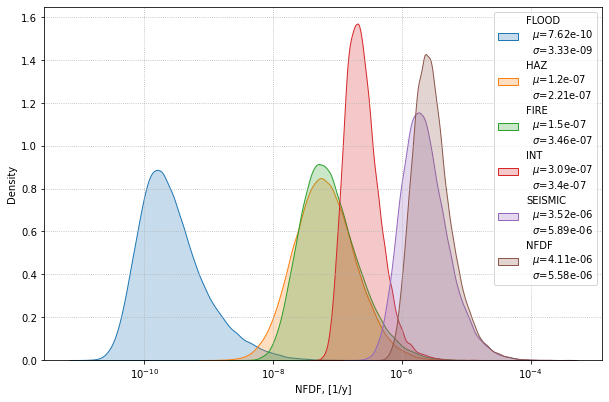

In [5]:
# Рисуем график ядерной оценки
f = plt.figure(figsize=(10, 6.5))
for name, unc in sorted(unc_data.items(), key=lambda x: x[1].mean()):
    ax= sns.kdeplot(
        unc,
        label=f'{name}\n  $\mu$={unc.mean():.3}\n  $\sigma$={unc.std():.3}',
        log_scale=True, shade=True)

ax= sns.kdeplot(
        nfdf,
        label=f'NFDF\n  $\mu$={nfdf.mean():.3}\n  $\sigma$={nfdf.std():.3}',
        log_scale=True, shade=True)
leg = ax.legend()
ax.grid(linestyle=':')
ax.set_xlabel('NFDF, [1/y]')

In [6]:
# Сохраняем график
#f.savefig('nfdf_pdf_contrib.png', format='png', dpi=300)

In [7]:
# Функция грубой апроксимации выборки по ближаёшему значению
inv_f = lambda cdf, value: 1 - (np.abs(cdf - value)).argmin()/(len(cdf)+0.5)

# Функция получения распределения вкладов по частоте и выборкам 
def get_contrib(f):
    return {name: inv_f(unc, f) for name, unc in sorted(unc_data.items(), key=lambda x: -x[1].mean() )}

## Вклады групп ИС при условии их попарной независимости

In [8]:
# Получаем таблицу вкладов в зависимости от частоты из учёта что все вклады независимы
df = pd.DataFrame(
    [[f]+list(get_contrib(f).values()) for f in np.geomspace(nfdf.max(), nfdf.min()/10)],
    columns=['f']+list(get_contrib(1e-1).keys()))

In [9]:
# Функций отрисовки вкладов в зависимости от частоты
def contrib_plot(df):
    ax = df.plot.area(x='f', figsize=(10, 6.5))
    ax.set_xscale('log')
    ax.grid(linestyle=':')
    ax.set_xlabel('NFDF, [1/y]')
    ax.set_ylabel('Contribute')

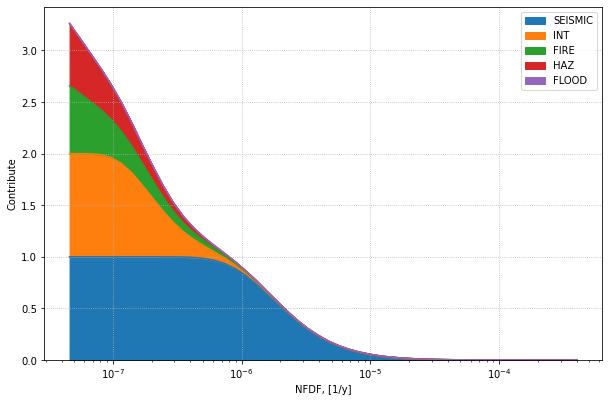

In [10]:
contrib_plot(df)

## Вклады групп ИС при условии их попарной несовместности

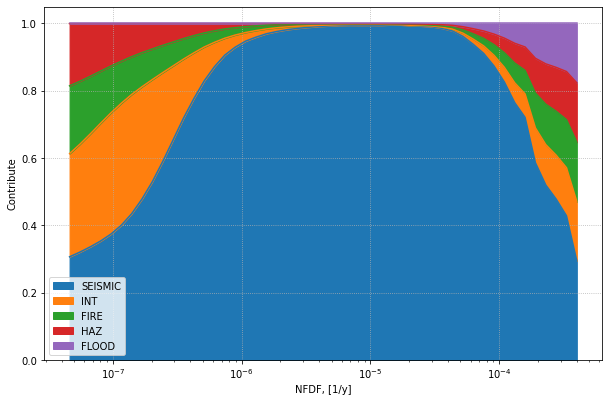

In [11]:
df[['FIRE', 'HAZ', 'SEISMIC', 'FLOOD', 'INT']] = df[['FIRE', 'HAZ', 'SEISMIC', 'FLOOD', 'INT']].divide(df[['FIRE', 'HAZ', 'SEISMIC', 'FLOOD', 'INT']].sum(axis=1), axis=0)
contrib_plot(df)

## Вклады групп ИС c учётом NFDF, при условии их попарной несовместности

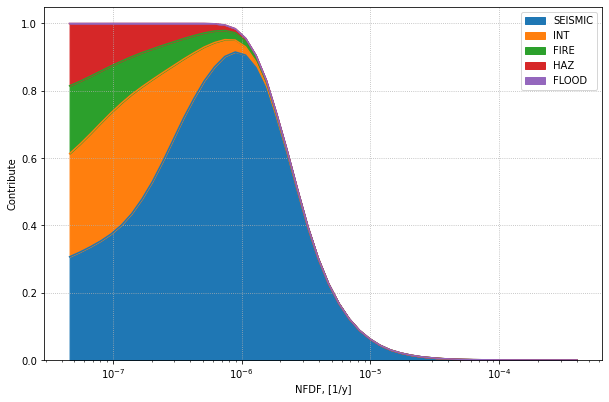

In [12]:
pp =[inv_f(nfdf,a) for a in df['f'].values]
df[['FIRE', 'HAZ', 'SEISMIC', 'FLOOD', 'INT']] = df[['FIRE', 'HAZ', 'SEISMIC', 'FLOOD', 'INT']].multiply(pp, axis=0)
contrib_plot(df)